# Face Mask Detection

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
physical_device = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

## Data Preprocessing

In [3]:
TRAINING_DIR = "dataset/training/"
VALIDATION_DIR = "dataset/validation/"

In [4]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

Found 3811 images belonging to 2 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                batch_size=10,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))

Found 22 images belonging to 2 classes.


## Create Model

In [6]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

In [7]:
x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(last_output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
int_lr = 1e-4
num_epochs = 20


optimizer = tf.optimizers.Adam(lr=int_lr, decay=int_lr/num_epochs)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training

In [9]:
H = model.fit(train_generator,
              steps_per_epoch=20,
              epochs=num_epochs,
              validation_data=validation_generator,
              validation_steps=3)

Epoch 1/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7532 - accuracy: 0.5776

C:\Users\Rahmat\anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 15s 514ms/step - loss: 0.7479 - accuracy: 0.5827 - val_loss: 0.5745 - val_accuracy: 0.6364
Epoch 2/20
20/20 [==============================] - 8s 383ms/step - loss: 0.4958 - accuracy: 0.8168 - val_loss: 0.4177 - val_accuracy: 0.9091
Epoch 3/20
20/20 [==============================] - 7s 370ms/step - loss: 0.3361 - accuracy: 0.9250 - val_loss: 0.3257 - val_accuracy: 0.9091
Epoch 4/20
20/20 [==============================] - 7s 360ms/step - loss: 0.2870 - accuracy: 0.9397 - val_loss: 0.2719 - val_accuracy: 0.9545
Epoch 5/20
20/20 [==============================] - 8s 392ms/step - loss: 0.2671 - accuracy: 0.9199 - val_loss: 0.2169 - val_accuracy: 0.9545
Epoch 6/20
20/20 [==============================] - 8s 378ms/step - loss: 0.2053 - accuracy: 0.9380 - val_loss: 0.1793 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 8s 374ms/step - loss: 0.1601 - accuracy: 0.9499 - val_loss: 0.1616 - val_accuracy: 0.9545
Epoch 8/20
20/20

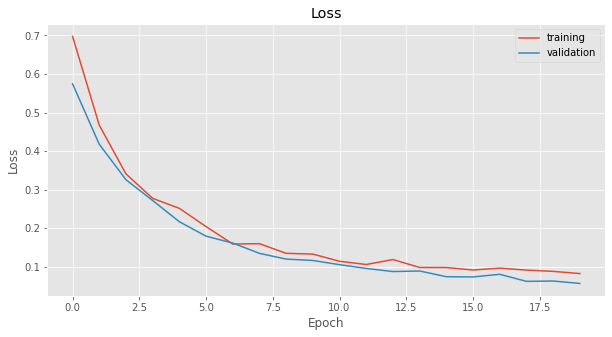

In [10]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/plot.png")

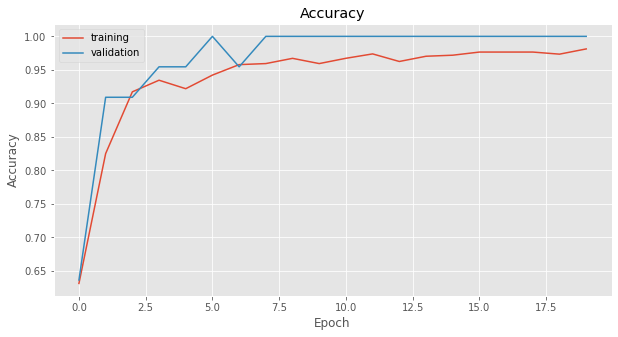

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/plot_acc.png")